<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a1/Question1_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Show the environment

In [1]:
!nvidia-smi

Sat Apr 17 10:22:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup logging

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

# Open and read the Fashion MNIST database
Code copied from sample provided

In [3]:

def get_fashion_mnist_data()->tuple:
  """
  Returns the training (X,Y) and evaluation (X,Y)
  The features have already been reshaped and converted to
  floats in the range [0,1]

  Also, the Y has been converted to categorical data.
  """
  # load the training and test data    
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  logging.debug( "Shape of training features " + str(tr_x.shape))
  logging.debug( "Shape of test features " + str(te_x.shape))
  
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  logging.debug("Shape of training labels " + str(tr_y.shape))
  
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  logging.debug("Shape of testing labels " + str(te_y.shape))

  tr_x = tf.convert_to_tensor(tr_x, dtype=tf.float32)
  tr_y = tf.convert_to_tensor(tr_y, dtype=tf.float32)
  te_x = tf.convert_to_tensor(te_x, dtype=tf.float32)
  te_y = tf.convert_to_tensor(te_y, dtype=tf.float32)

  return tr_x, tr_y, te_x, te_y

# Some utility functions
1. Forward Pass
2. Cross Entropy
3. Accuracy Score
4. Flatten Network
5. Optimize Network (Adam)

In [4]:
def make_layer(shape:list, layername:str)->tf.Variable:
  return tf.Variable(tf.random.normal(shape, mean=0, stddev=0.05, \
                                      dtype=tf.dtypes.float32),
                                      name=layername)

# This function implements the softmax function
def softmax(a:tf.Tensor, axis:int=None)->tf.Tensor:
  t = tf.math.exp(a)
  s = tf.reduce_sum(t, axis=0)
  return tf.math.divide(t, s)

# This function implements the cross-entropy loss
def cross_entropy(y_true, y_pred)->tf.Tensor:
  # First clip the values to 1.0 x 10^(-8) because if there
  # are any values which are 0, then this will cause an error
  y_pred = tf.clip_by_value(y_pred, \
                            clip_value_min=1.0e-10, \
                            clip_value_max=tf.reduce_max(y_pred))
  y_pred = tf.math.multiply(y_true, tf.math.log(y_pred))
  y_pred = tf.multiply(y_pred, -1)
  # Find the average cross entropy, divide by number of samples
  divisor = y_pred.shape[1] if len(y_pred.shape) > 1 else 1
  y_pred = tf.math.divide(tf.reduce_sum(y_pred), divisor)
  return y_pred

# This function gets the accuracy
def accuracy(y_true:tf.Tensor, y_pred:tf.Tensor)->float:
  logging.debug("y_true = " + str(y_true.shape) + \
                " y_pred = " + str(y_pred.shape))
  y_true = tf.transpose(y_true)
  logging.debug("y_true = " + str(y_true.shape) + \
                " y_pred = " + str(y_pred.shape))
  eq = tf.math.equal(y_true, y_pred)
  return float(eq[eq == True].shape[0]) / float(eq.shape[0])

# This function finds the mean absolute error
def mean_absolute_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  y_true = tf.transpose(y_true)
  logging.debug(y_true.shape, y_pred.shape)
  abs_dist = tf.math.abs(tf.math.subtract(y_true, y_pred))
  return tf.reduce_mean(abs_dist)

# This function finds the mean square error
def mean_square_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

# This function finds the mean square error after multiplying each
# value by 255 (since we would have converted the range [0,255] to the range
# [0, 1])
def mean_square_error_image(yt:tf.Tensor, yp:tf.Tensor)->tf.Variable:
  y1 = tf.math.multiply(yt, 255.0)
  y2 = tf.math.multiply(yp, 255.0)
  return mean_square_error(tf.transpose(y1), y2)

# Neural network class for reuse
class NeuralNetwork(object):

  def __init__(self, network, dropout_probability=0.3):
    # the network contains the matrices that describe each layer
    self.network = network
    # The dropout probability
    self.prob_dropout = dropout_probability
    # Store the result of each iteration
    self.iterations = []
    self.train_accuracies = []
    self.test_accuracies = []
    self.train_losses = []
    self.test_losses = []

  def print_drop_matrix_stat(self, d:tf.Tensor)->None:
    ones = tf.ones(shape=d.shape)
    all = tf.reduce_sum(ones)
    this = tf.reduce_sum(d)
    logging.debug(tf.divide(this, all))

  # A slight variation of convention is used here, the dropout is applied to
  # the input of a layer, rather than the output. This doesn't make any
  # difference as the definition of the model is changed to achieve the same
  # result
  def get_dropout_input(self, input:tf.Tensor)->tf.Tensor:
    prob_dropout = self.prob_dropout
    prob_threshold = 1 - prob_dropout
    drop_matrix = tf.random.uniform(shape=input.shape, minval=0,  maxval=1)
    drop_matrix = tf.math.less(drop_matrix, prob_threshold)
    drop_matrix = tf.cast(drop_matrix, dtype=tf.float32)
    input = tf.math.multiply(input, drop_matrix)
    input = tf.math.divide(input, prob_threshold)
    return input

  # The forward pass function, pushes the input through all the layers
  # the parameter layers is a list of tuples, each tuple is of the form
  # (
  #    weight-matrix:list,
  #    bias-matrix:list,
  #    activation_function, 
  #    is_dropout_enabled:bool
  # )
  def forward_pass(self, tr_x, tr_y, layers:list):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in layers:
        # If dropout is enabled on the layer, apply dropout on the input
        if dropout:
          input = self.get_dropout_input(input)
        input = activation(tf.matmul(weight, input) + bias)
    return input
  
  def predict(self, tr_x, tr_y):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in self.network:
      input = activation(tf.matmul(weight, input) + bias)
    return input
  
  """
  Take a network which is a list of tuples, and flatten it
  to a list, so that we can call adam and gradient on it without 
  without any ugly code
  """
  def flatten_network(self, network:list)->list:
    out = []
    for weight, bias, act, dropout in network:
      out.append(weight)
      out.append(bias)
    return out
  
  """
  Use the adam optimizer to optimize a network based on the 
  gradients passed to it
  """
  def optimize_network(self, network:list, gradients:list)->None:
    adam_optimizer = tf.keras.optimizers.Adam()
    learnable_array = []
    adam_optimizer.apply_gradients(zip(gradients, \
                                       self.flatten_network(network)))
  
  def should_log(self, i:int, iterations:int):
    return (i == (iterations - 1)) or all([i == '0' for i in list(str(i)[1:])])
  
  """
  Train the network for a given number of iterations
  """
  def train_network(self, \
                    iterations:int, \
                    tr_x:tf.Tensor, tr_y:tf.Tensor, \
                    te_x:tf.Tensor, te_y:tf.Tensor, \
                    loss_fn, acc_fn, \
                    do_logging=True, \
                    use_argmax=True)->None:
    for i in range(iterations):

      # Call forward pass on the network and use the gradient tape
      with tf.GradientTape() as tape:
        y_pred = self.forward_pass(tr_x, tr_y, self.network)
        loss = loss_fn(tr_y, y_pred)
      gradients = tape.gradient(loss, self.flatten_network(self.network))

      # Record the training accuracy before updating the weights
      if (use_argmax):
        tr_acc = acc = acc_fn(tf.argmax(tr_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        tr_acc = acc = acc_fn(tr_y, y_pred) if None != acc_fn else float("NaN")
      tr_loss = loss

      # Log the same if required
      if do_logging and self.should_log(i, iterations):
        printstr = f"Iteration {i:5d}  TRAIN LOSS - {loss:5.5f}  "
        printstr = printstr + f"TRAIN ACCURACY - {acc:5.5f}"

      # Now run the prediction on the test set, and record the accuracy
      # We haven't updated the weights yet
      y_pred = self.predict(te_x, te_y)
      te_loss = loss = loss_fn(te_y, y_pred)
      if (use_argmax):
        te_acc = acc = acc_fn(tf.argmax(te_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        te_acc = acc = acc_fn(te_y, y_pred) if None != acc_fn else float("NaN")

      # Log if required
      if do_logging and self.should_log(i, iterations):
        printstr = printstr + f"  TEST_LOSS = {loss:5.5f}  "
        printstr = printstr + f"TEST ACCURACY = {acc:5.5f}"
        logging.info(printstr)

      # Record the performance of this run
      self.iterations.append(i)
      self.train_accuracies.append(tr_acc)
      self.train_losses.append(tr_loss)
      self.test_accuracies.append(te_acc)
      self.test_losses.append(te_loss)

      # Now use ADAM and update the weights
      self.optimize_network(self.network, gradients)

    self.iterations = np.array(self.iterations)
    self.train_accuracies = np.array(self.train_accuracies)
    self.train_losses = np.array(self.train_losses)
    self.test_accuracies = np.array(self.test_accuracies)
    self.test_losses = np.array(self.test_losses)

# Question 1_2_1

## Create the network with dropout

In [5]:
def q_1_2_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
             make_layer([300, 1],   "L1 Bias", ),
             tf.nn.relu,
             False),
            # Layer 2, 100 nodes, ReLu, dropout (dropout applied on input)
            (make_layer([100, 300], "L2 Weights", ),
             make_layer([100, 1],   "L2 Bias", ),
             tf.nn.relu,
             True),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
             make_layer([10, 1],    "L3 Bias", ),
             softmax,
             False),]
  nn = NeuralNetwork(network, 0.5)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)

  return nn

## Run the network and plot the graph

2021-04-17 10:22:04,164 - root - INFO - Iteration     0  TRAIN LOSS - 2.31007  TRAIN ACCURACY - 0.10513  TEST_LOSS = 2.30671  TEST ACCURACY = 0.10450
2021-04-17 10:22:04,206 - root - INFO - Iteration     1  TRAIN LOSS - 2.20025  TRAIN ACCURACY - 0.18985  TEST_LOSS = 2.18782  TEST ACCURACY = 0.21640
2021-04-17 10:22:04,242 - root - INFO - Iteration     2  TRAIN LOSS - 2.09138  TRAIN ACCURACY - 0.30703  TEST_LOSS = 2.06758  TEST ACCURACY = 0.40190
2021-04-17 10:22:04,277 - root - INFO - Iteration     3  TRAIN LOSS - 1.97140  TRAIN ACCURACY - 0.42610  TEST_LOSS = 1.93349  TEST ACCURACY = 0.53120
2021-04-17 10:22:04,313 - root - INFO - Iteration     4  TRAIN LOSS - 1.84236  TRAIN ACCURACY - 0.50218  TEST_LOSS = 1.78614  TEST ACCURACY = 0.58640
2021-04-17 10:22:04,350 - root - INFO - Iteration     5  TRAIN LOSS - 1.70170  TRAIN ACCURACY - 0.54472  TEST_LOSS = 1.63150  TEST ACCURACY = 0.59680
2021-04-17 10:22:04,387 - root - INFO - Iteration     6  TRAIN LOSS - 1.55933  TRAIN ACCURACY - 0.57

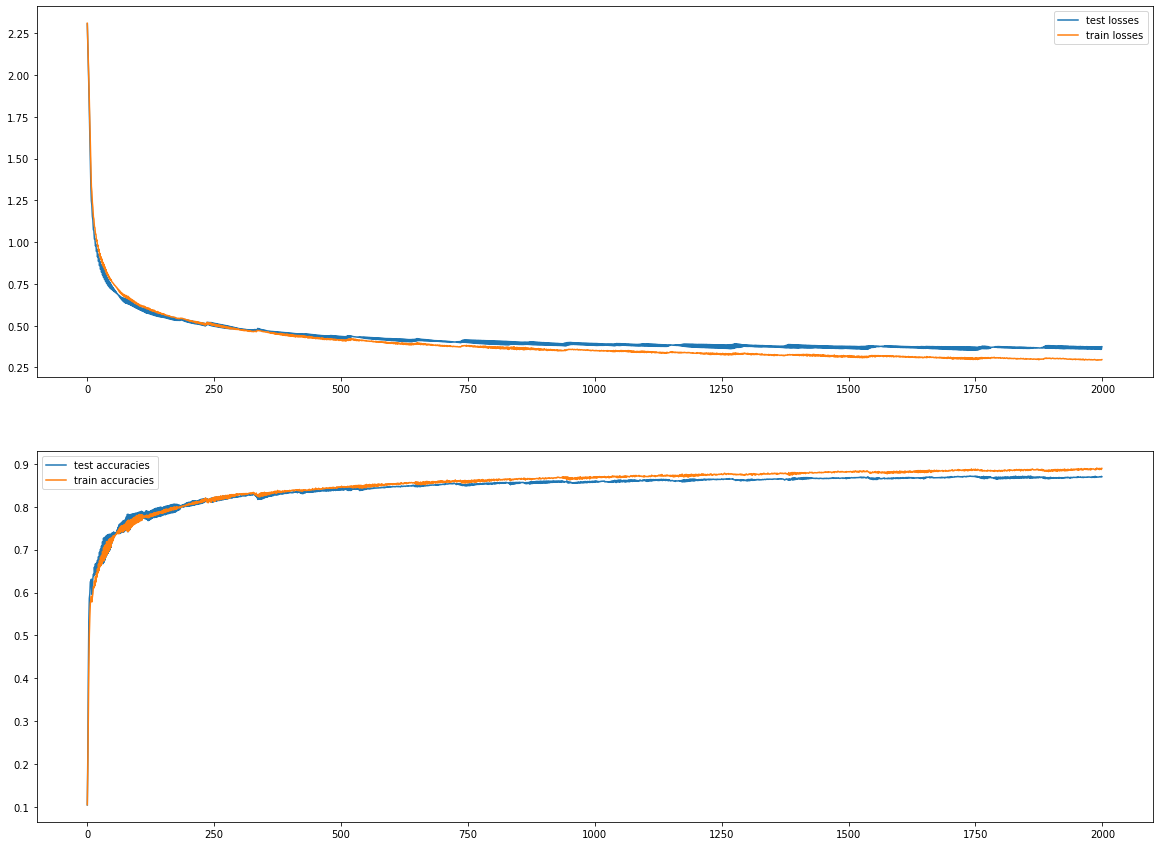

In [6]:
import matplotlib.pyplot as plt
import random

nn = q_1_2_1()

plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

## Try the same thign without dropout and see the results

2021-04-17 10:23:09,630 - root - INFO - Iteration     0  TRAIN LOSS - 2.32579  TRAIN ACCURACY - 0.09370  TEST_LOSS = 2.32576  TEST ACCURACY = 0.09250
2021-04-17 10:23:09,663 - root - INFO - Iteration     1  TRAIN LOSS - 2.19898  TRAIN ACCURACY - 0.24042  TEST_LOSS = 2.19957  TEST ACCURACY = 0.23980
2021-04-17 10:23:09,695 - root - INFO - Iteration     2  TRAIN LOSS - 2.06480  TRAIN ACCURACY - 0.44807  TEST_LOSS = 2.06622  TEST ACCURACY = 0.44380
2021-04-17 10:23:09,726 - root - INFO - Iteration     3  TRAIN LOSS - 1.91866  TRAIN ACCURACY - 0.51430  TEST_LOSS = 1.92133  TEST ACCURACY = 0.51200
2021-04-17 10:23:09,759 - root - INFO - Iteration     4  TRAIN LOSS - 1.76746  TRAIN ACCURACY - 0.58150  TEST_LOSS = 1.77115  TEST ACCURACY = 0.57490
2021-04-17 10:23:09,794 - root - INFO - Iteration     5  TRAIN LOSS - 1.61836  TRAIN ACCURACY - 0.58120  TEST_LOSS = 1.62300  TEST ACCURACY = 0.57690
2021-04-17 10:23:09,829 - root - INFO - Iteration     6  TRAIN LOSS - 1.47763  TRAIN ACCURACY - 0.64

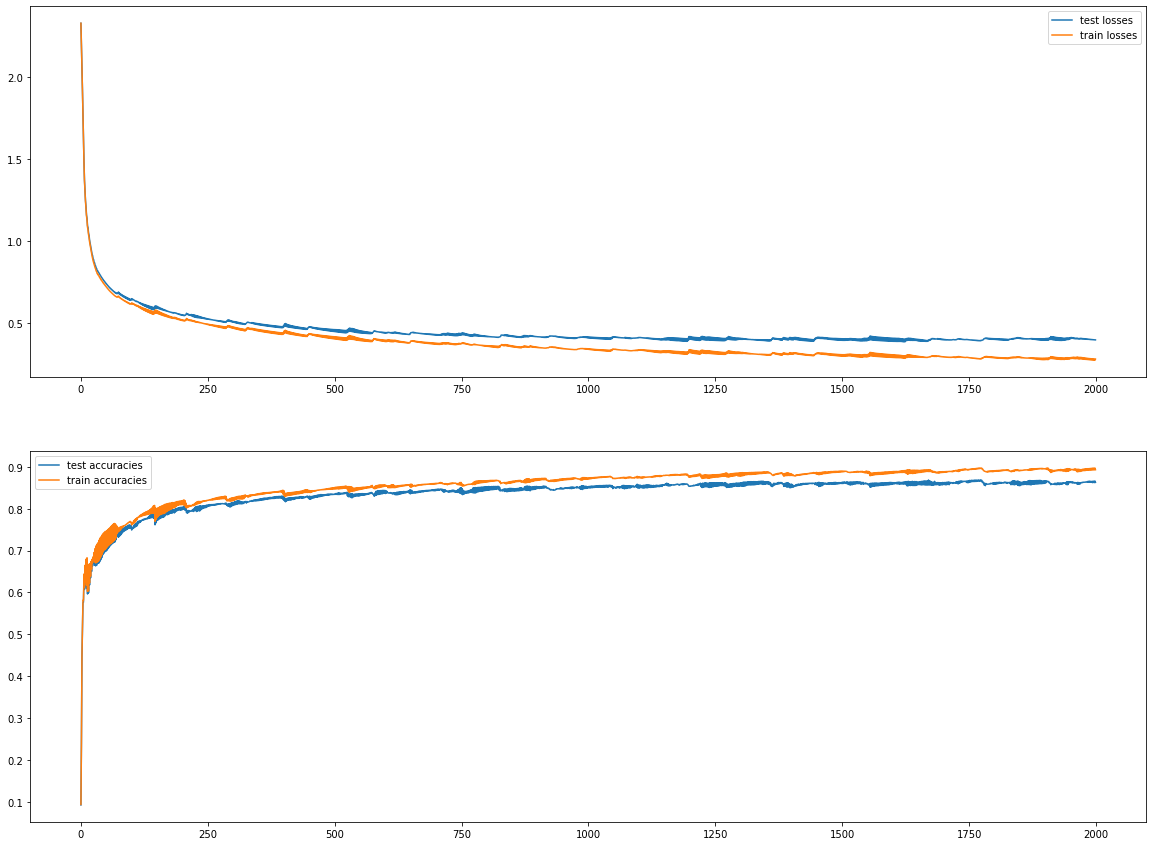

In [7]:
def q_1_2_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
             make_layer([300, 1],   "L1 Bias", ),
             tf.nn.relu,
             False),
            # Layer 2, 100 nodes, ReLu, dropout
            (make_layer([100, 300], "L2 Weights", ),
             make_layer([100, 1],   "L2 Bias", ),
             tf.nn.relu,
             False),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
             make_layer([10, 1],    "L3 Bias", ),
             softmax,
             False),]
  nn = NeuralNetwork(network)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)

  return nn


import matplotlib.pyplot as plt
import random

nn = q_1_2_1()

plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
ax[1].legend()
plt.show()

## See how things change as the dropout rate is changed

2021-04-17 10:24:07,550 - root - INFO - Training with dropout rate = 0
2021-04-17 10:25:11,742 - root - INFO - Dropout:   0  Train Accuracy: 0.89088     Test Accuracy: 0.85570     Train Loss: 0.29594     Test Loss: 0.42337
2021-04-17 10:25:12,270 - root - INFO - Training with dropout rate = 5
2021-04-17 10:26:16,616 - root - INFO - Dropout:   5  Train Accuracy: 0.89602     Test Accuracy: 0.86720     Train Loss: 0.28399     Test Loss: 0.39901
2021-04-17 10:26:17,119 - root - INFO - Training with dropout rate = 10
2021-04-17 10:27:21,454 - root - INFO - Dropout:  10  Train Accuracy: 0.89632     Test Accuracy: 0.86880     Train Loss: 0.28543     Test Loss: 0.39619
2021-04-17 10:27:21,953 - root - INFO - Training with dropout rate = 15
2021-04-17 10:28:26,197 - root - INFO - Dropout:  15  Train Accuracy: 0.89170     Test Accuracy: 0.86720     Train Loss: 0.28128     Test Loss: 0.37651
2021-04-17 10:28:26,700 - root - INFO - Training with dropout rate = 20
2021-04-17 10:29:31,048 - root - I

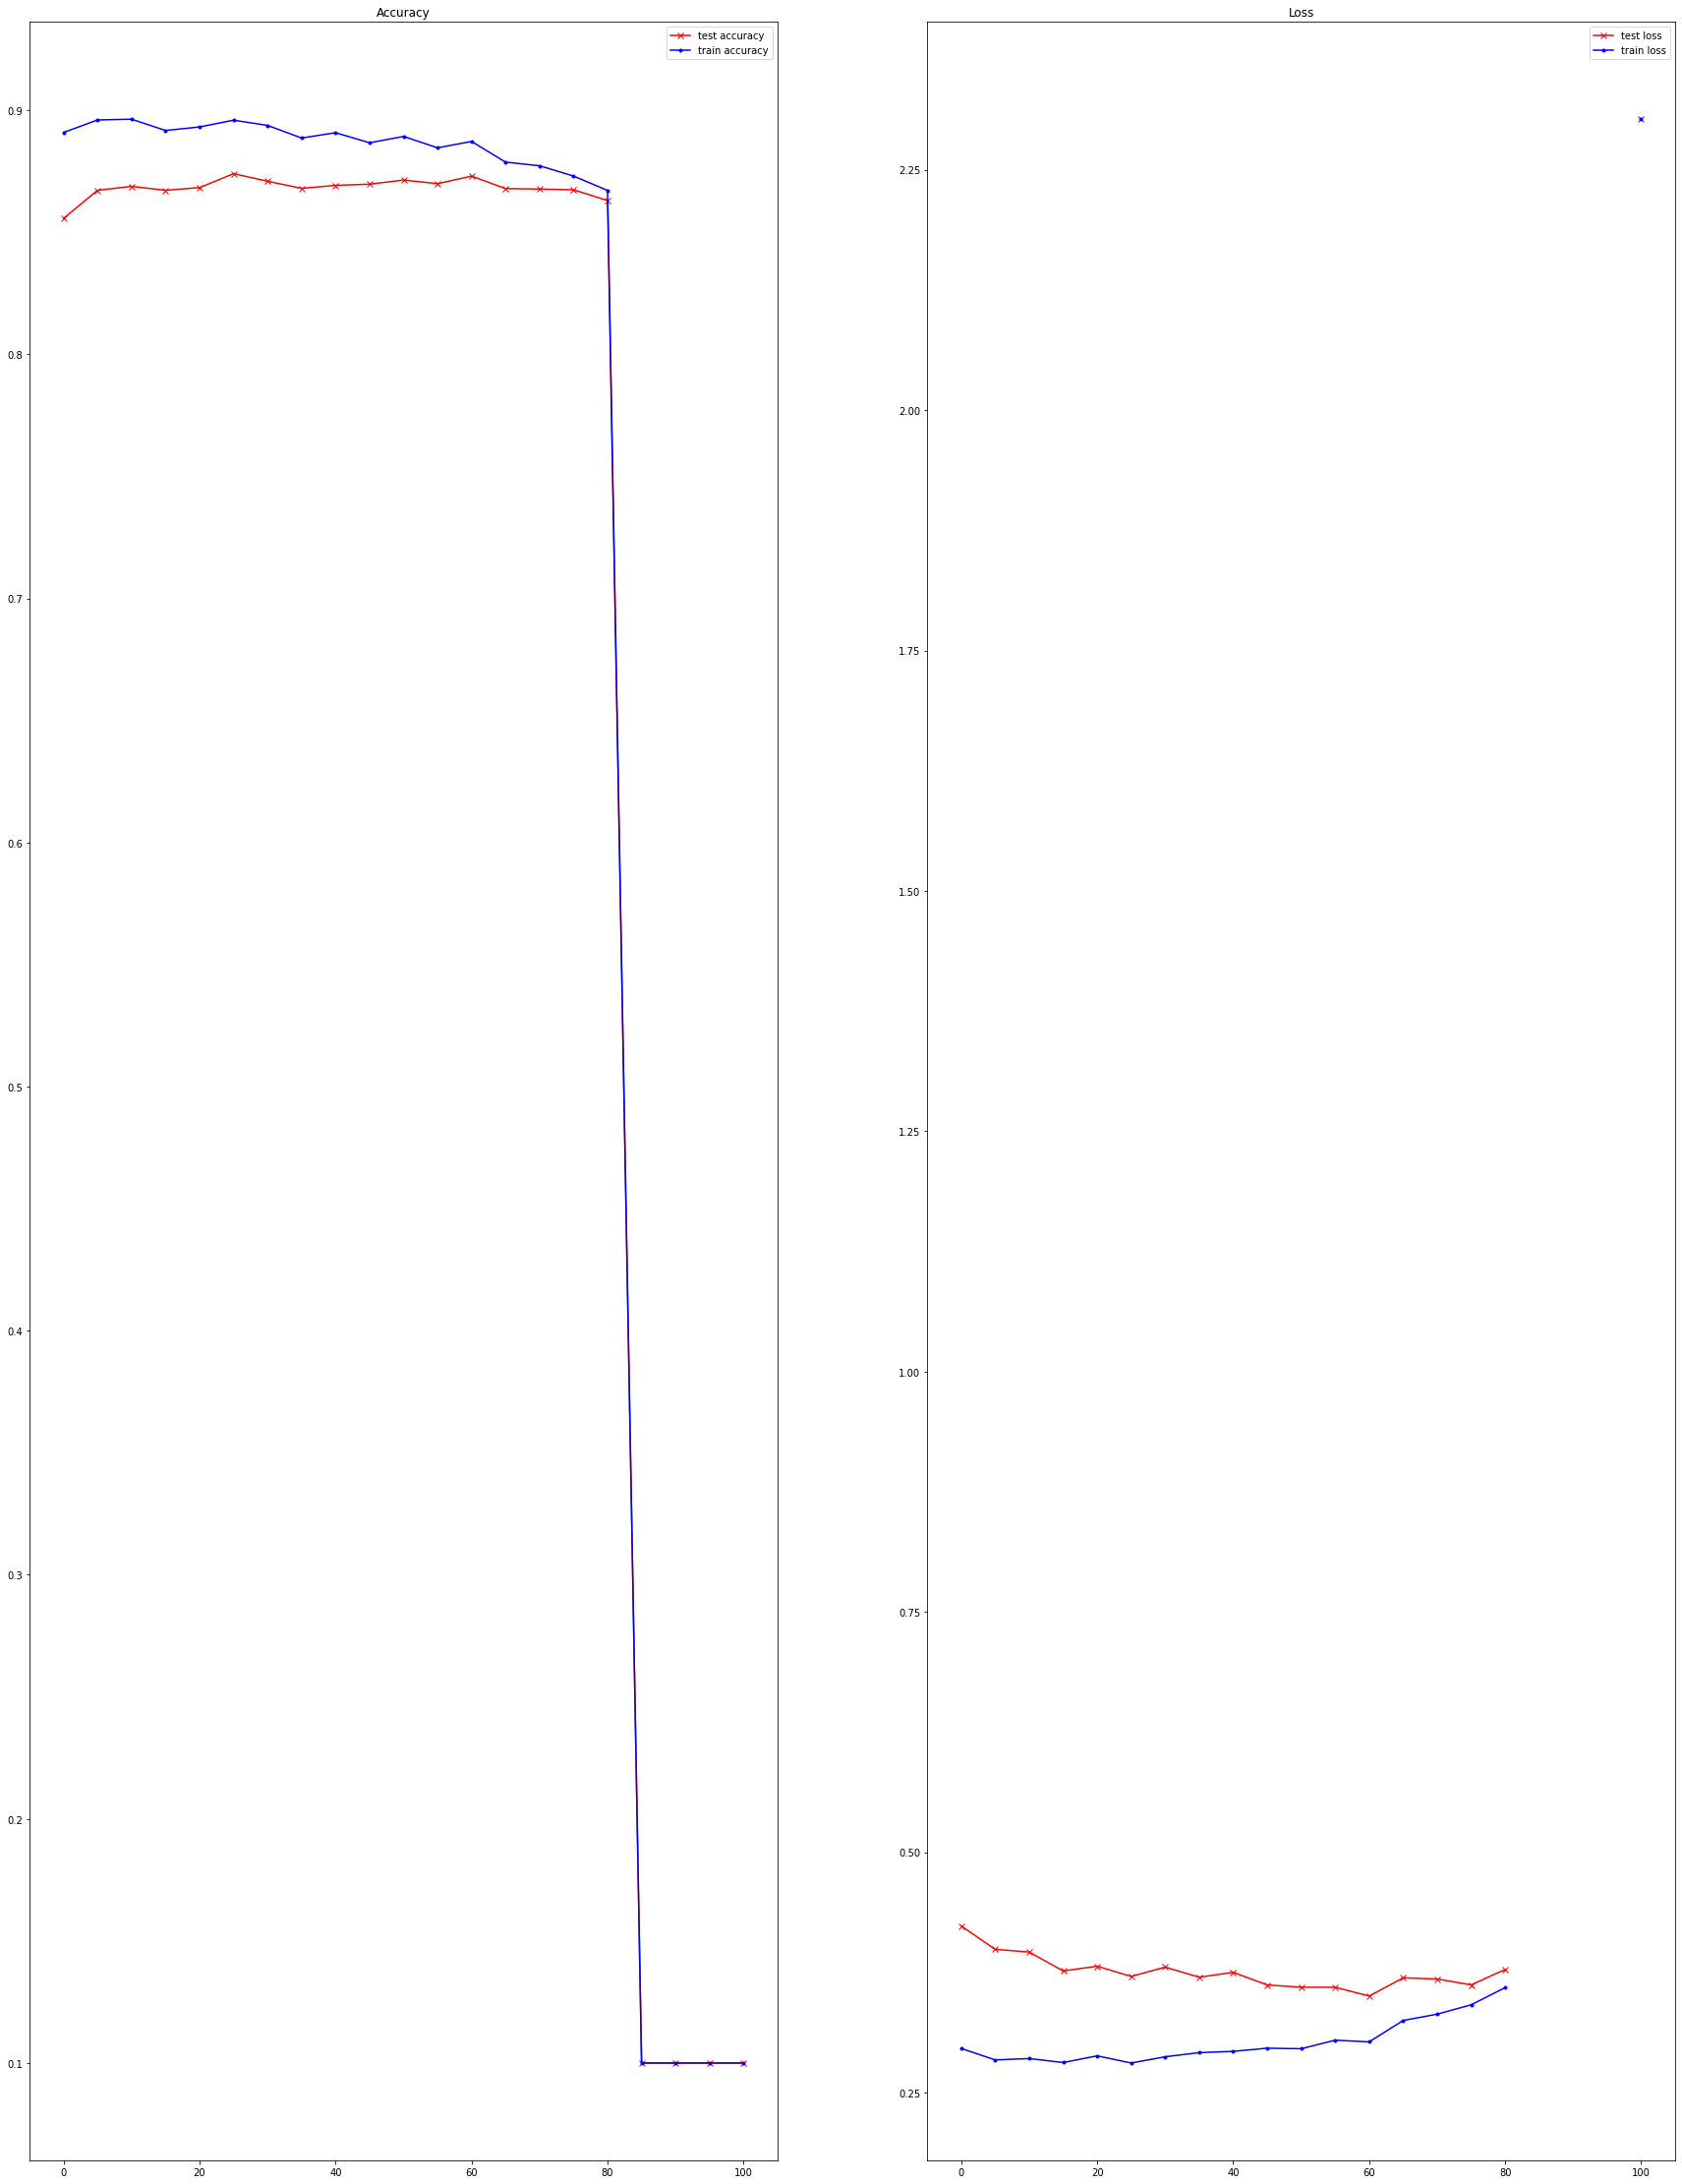

In [8]:
def norm(x):
  return -1 if x == None or x < 0 or x == float("NaN") else x

record = []
for i in range(0, 101, 5):
  tf.random.set_seed(0)
  np.random.seed(0)
  random.seed(0)
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
              make_layer([300, 1],   "L1 Bias", ),
              tf.nn.relu,
              False),
            # Layer 2, 100 nodes, ReLu, dropout
            (make_layer([100, 300], "L2 Weights", ),
              make_layer([100, 1],   "L2 Bias", ),
              tf.nn.relu,
              True),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
              make_layer([10, 1],    "L3 Bias", ),
              softmax,
              False),]

  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  dropout_prob = i / 100.0
  logging.info(f"Training with dropout rate = {i}")
  nn = NeuralNetwork(network, dropout_probability=dropout_prob)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, \
                   cross_entropy, accuracy, do_logging=False)
  test_accuracy = norm(nn.test_accuracies[-1])
  test_loss = norm(nn.test_losses[-1])
  train_accuracy = norm(nn.train_accuracies[-1])
  train_loss = norm(nn.train_losses[-1])
  record.append((i, test_accuracy, test_loss, train_accuracy, train_loss, ))
  logging.info(f"Dropout: {i:3d}  Train Accuracy: {train_accuracy:5.5f}     " +
               f"Test Accuracy: {test_accuracy:5.5f}     " +
               f"Train Loss: {train_loss:5.5f}     " +
               f"Test Loss: {test_loss:5.5f}")

def myplot(ax, record:list, index:int, colr:str, labstr:str):
  x_axis = [item[0] for item in record]
  y_axis = [item[index] for item in record]
  markr = 'x' if colr == 'red' else '.'
  ax.plot(x_axis, y_axis, label=labstr, marker=markr, color=colr)


plt.rcParams["figure.figsize"] = (30, 40)
fig, ax = plt.subplots(1, 2)
myplot(ax[0], record, 1, 'red', 'test accuracy')
myplot(ax[1], record, 2, 'red', 'test loss')
myplot(ax[0], record, 3, 'blue', 'train accuracy')
myplot(ax[1], record, 4, 'blue', 'train loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].legend()
ax[1].legend()
plt.show()